In [1]:
!pip3 install -U -q wandb gdown
!wandb login 6e6ad89112a80767ba11f981192ce27998246acb
!gdown --id 10asz6FL3elHDa16GUVvIAAXiG4G7an1e

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
/opt/conda/lib/python3.7/site-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=10asz6FL3elHDa16GUVvIAAXiG4G7an1e
To: /kaggle/working/checkpoint-last-224.ckpt
100%|██████████████████████████████████████| 32.3M/32.3M [00:00<00:00, 53.9MB/s]


In [2]:
!pip3 install torch_ort -q

## Setup

In [3]:
import json
import os
import random
from typing import Dict
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torchvision
from PIL import Image, ImageDraw
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, ConcatDataset, Dataset
from torchvision import transforms
from tqdm.auto import tqdm

filterwarnings("ignore", category=DeprecationWarning)
filterwarnings("ignore", category=FutureWarning)
filterwarnings("ignore", category=UserWarning)
sns.set_theme()

In [4]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


seed_everything(20212022)

In [5]:
try:
    import wandb

    wandb.init(project="draw-with-us", entity="trinhdvt", settings=wandb.Settings(start_method="thread"))
except:
    pass

wandb: Currently logged in as: trinhdvt. Use `wandb login --relogin` to force relogin


In [6]:
N_FILE = 100
N_FILE_TRAIN = 15
N_FILE_VALID = 2
ROOT_DIR = "../input/shuffle-csvs"


def gen_ds_file():
    rand_arr = np.random.permutation(N_FILE)
    train_files = [os.path.join(ROOT_DIR, f"train_k{i}.csv.gz") for i in rand_arr[:N_FILE_TRAIN]]
    val_files = [os.path.join(ROOT_DIR, f"train_k{i}.csv.gz") for i in rand_arr[-N_FILE_VALID:]]
    return train_files, val_files


train_files, val_files = gen_ds_file()
print("train_files : ", train_files)
print("val_files : ", val_files)

def encode_labels():
    sample_file = "../input/shuffle-csvs/train_k0.csv.gz"
    sample_df = pd.read_csv(sample_file, usecols=['word', 'y']).drop_duplicates('word', keep='first')
    label2idx = {x: y for x, y in zip(sample_df['word'], sample_df['y'])}
    idx2label = {v: k for k, v in label2idx.items()}
    with open('classes.json', 'w') as f:
        dump_data = {"en_dict": label2idx, "dec_dict": idx2label}
        json.dump(dump_data, f, ensure_ascii=False)

    return label2idx, idx2label


en_dict, dec_dict = encode_labels()

train_files :  ['../input/shuffle-csvs/train_k41.csv.gz', '../input/shuffle-csvs/train_k67.csv.gz', '../input/shuffle-csvs/train_k46.csv.gz', '../input/shuffle-csvs/train_k57.csv.gz', '../input/shuffle-csvs/train_k34.csv.gz', '../input/shuffle-csvs/train_k17.csv.gz', '../input/shuffle-csvs/train_k39.csv.gz', '../input/shuffle-csvs/train_k51.csv.gz', '../input/shuffle-csvs/train_k18.csv.gz', '../input/shuffle-csvs/train_k92.csv.gz', '../input/shuffle-csvs/train_k31.csv.gz', '../input/shuffle-csvs/train_k8.csv.gz', '../input/shuffle-csvs/train_k88.csv.gz', '../input/shuffle-csvs/train_k69.csv.gz', '../input/shuffle-csvs/train_k29.csv.gz']
val_files :  ['../input/shuffle-csvs/train_k0.csv.gz', '../input/shuffle-csvs/train_k9.csv.gz']


## Custom Dataset

In [7]:
class DoodleDataset(Dataset):
    def __init__(self,
                 filepath: str,
                 nrows=None,
                 skiprows=None,
                 size: int = 256,
                 transforms=None):

        self.size = size
        self.transforms = transforms
        self.data = pd.read_csv(filepath, usecols=['drawing', 'word', 'y'], nrows=nrows, skiprows=skiprows)

    @staticmethod
    def _draw(strokes, size, lw=6):
        BASE_SIZE = 256
        pil_img = Image.new('P', (BASE_SIZE, BASE_SIZE), color=255)
        img_draw = ImageDraw.Draw(pil_img)

        for stroke in strokes:
            for i in range(len(stroke[0]) - 1):
                img_draw.line((stroke[0][i], stroke[1][i], stroke[0][i + 1], stroke[1][i + 1]),
                              fill=0,
                              width=lw)

        if BASE_SIZE != size:
            pil_img = pil_img.resize((size, size))

        return pil_img

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        stroke = json.loads(self.data['drawing'][idx])
        img = self._draw(stroke, self.size)

        if self.transforms:
            img = self.transforms(img)

        return img, self.data['y'][idx]

## Model

In [8]:
class DrawClassifier(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()

        self.net = torchvision.models.mobilenet_v2(pretrained=True)
        self.net.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1280, num_classes)
        )

    def forward(self, x):
        return self.net(x)

## Custom Trainer

In [9]:
class Trainer:
    def __init__(self,
                 model: nn.Module,
                 optimizer: torch.optim.Optimizer,
                 criterion: nn.Module,
                 scheduler=None,
                 ckpt_path: str = None):

        self.optimizer = optimizer
        self.criterion = criterion
        self.scheduler = scheduler
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.train_hist = {
            "train_loss": [],
            "train_acc": [],
            "val_loss": [],
            "val_acc": []
        }
        self.model = model.to(self.device)
        if ckpt_path is not None:
            self.load_checkpoint(ckpt_path)
        
        try:
            from torch_ort import ORTModule
            self.model = ORTModule(self.model)
        except:
            pass

    def train(self,
              dataloader: Dict[str, DataLoader],
              num_epochs: int = 25,
              verbose: int = 1,
              best_model_path: str = "./best_model.pth"):

        best_acc = 0.0

        for epoch in range(1, num_epochs + 1):
            if epoch % verbose == 0:
                print(f'Epoch {epoch}/{num_epochs}')
                print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                else:
                    self.model.eval()

                running_loss = 0.0
                running_corrects = 0
                total = 0

                # Iterate over data.
                stream = tqdm(dataloader[phase])
                for inputs, labels in stream:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)

                    # zero the parameter gradients
                    self.optimizer.zero_grad()

                    # forward
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = self.criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            self.optimizer.step()

                    # statistics
                    total += labels.size(0)
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / total
                epoch_acc = running_corrects.double() / total

                if phase == 'val' and self.scheduler is not None:
                    self.scheduler.step(epoch_loss)

                if epoch % verbose == 0:
                    print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                self.train_hist[f'{phase}_loss'].append(epoch_loss)
                self.train_hist[f'{phase}_acc'].append(epoch_acc.item())

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(self.model.state_dict(), best_model_path)
                    self.save_checkpoint("checkpoint-best.ckpt")

            print()
            self.save_checkpoint()
            try:
                wandb.log({
                    "Loss/Train": self.train_hist['train_loss'][-1],
                    "Loss/Validation": self.train_hist['val_loss'][-1],
                    "Accuracy/Train": self.train_hist['train_acc'][-1],
                    "Accuracy/Validation": self.train_hist['val_acc'][-1]
                })
            except:
                pass

        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        self.model.load_state_dict(torch.load(best_model_path, map_location=self.device))
        return self.model

    def save_checkpoint(self, filename="checkpoint-last.ckpt"):
        checkpoint = {
            "model_state_dict": self.model.state_dict(),
            "optimizer_state_dict": self.optimizer.state_dict(),
            "scheduler_state_dict": self.scheduler.state_dict(),
        }
        torch.save(checkpoint, filename)

    def load_checkpoint(self, ckpt_path):
        checkpoint = torch.load(ckpt_path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
        self.model.to(self.device)
        print("Load from checkpoint done!")
        

## Data preparation

In [10]:
data_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

IN_SIZE = 224
# IN_ROWS = 2500
# VAL_ROWS = 500

train_ds = ConcatDataset([
    DoodleDataset(fn, size=IN_SIZE, transforms=data_transforms)
    for fn in train_files
])
val_ds = ConcatDataset([
    DoodleDataset(fn, size=IN_SIZE, transforms=data_transforms)
    for fn in val_files
])

BATCH_SIZE = 256
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

Train dataset size: 1529267
Validation dataset size: 203386


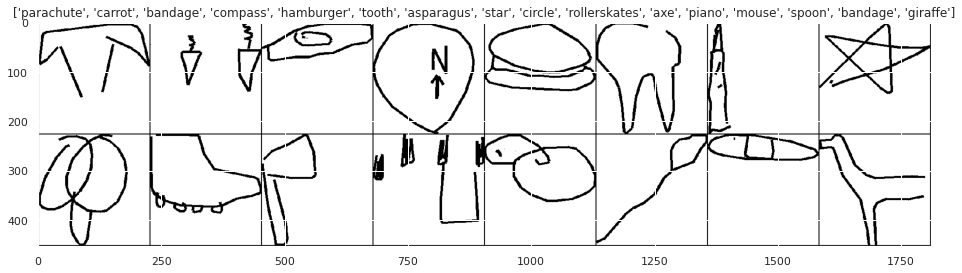

In [11]:
print("Train dataset size:", len(train_ds))
print("Validation dataset size:", len(val_ds))

dataloader = {
    "train": train_loader,
    "val": val_loader
}


def imshow(img, title=''):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()


images, label = next(iter(dataloader['train']))

plt.figure(figsize=(16, 24))
n_sample = 16
img_title = [dec_dict[l.item()] for l in label[:n_sample]]
imshow(torchvision.utils.make_grid(images[:n_sample]), title=str(img_title))

## Training

In [12]:
n_classes = len(en_dict.keys())
train_model = DrawClassifier(n_classes)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(train_model.parameters(), lr=0.002)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.75, patience=1, verbose=True)
checkpoint_path = "./checkpoint-last-224.ckpt"
trainer = Trainer(train_model, optimizer, criterion, scheduler, checkpoint_path)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

Load from checkpoint done!


In [13]:
# %%time

MAX_EPOCHS = 5
VERBOSE = 1
best_model = trainer.train(dataloader, num_epochs=MAX_EPOCHS, verbose=VERBOSE, best_model_path="mobile_net_256_large.pth")

Epoch 1/5
----------


  0%|          | 0/5974 [00:00<?, ?it/s]

train Loss: 0.6195 Acc: 0.8316


  0%|          | 0/795 [00:00<?, ?it/s]

val Loss: 0.8727 Acc: 0.7836

Epoch 2/5
----------


  0%|          | 0/5974 [00:00<?, ?it/s]

train Loss: 0.6030 Acc: 0.8354


  0%|          | 0/795 [00:00<?, ?it/s]

Epoch    17: reducing learning rate of group 0 to 8.4375e-04.
val Loss: 0.8808 Acc: 0.7827

Epoch 3/5
----------


  0%|          | 0/5974 [00:00<?, ?it/s]

train Loss: 0.5724 Acc: 0.8433


  0%|          | 0/795 [00:00<?, ?it/s]

val Loss: 0.8848 Acc: 0.7845

Epoch 4/5
----------


  0%|          | 0/5974 [00:00<?, ?it/s]

train Loss: 0.5567 Acc: 0.8466


  0%|          | 0/795 [00:00<?, ?it/s]

Epoch    19: reducing learning rate of group 0 to 6.3281e-04.
val Loss: 0.8965 Acc: 0.7835

Epoch 5/5
----------


  0%|          | 0/5974 [00:00<?, ?it/s]

train Loss: 0.5280 Acc: 0.8542


  0%|          | 0/795 [00:00<?, ?it/s]

val Loss: 0.9089 Acc: 0.7831

Best val Acc: 0.784508


## Visualization training history

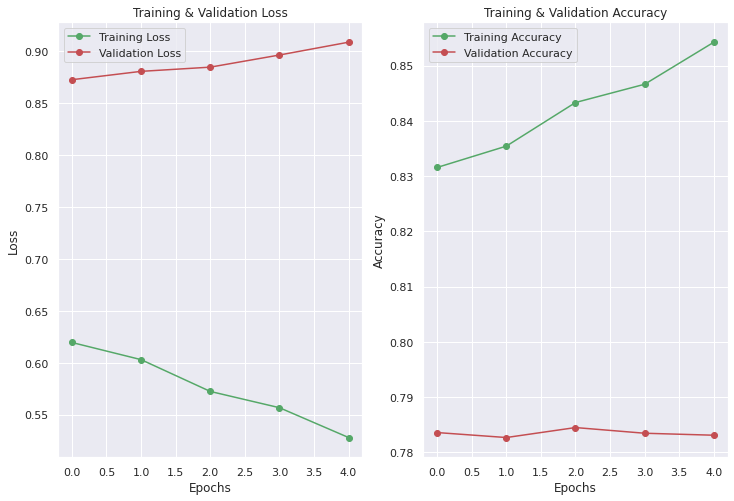

In [14]:
def plot_train_history(train_history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8))
    epochs = list(range(MAX_EPOCHS))
    train_loss = train_history['train_loss']
    val_loss = train_history['val_loss']
    train_acc = train_history['train_acc']
    val_acc = train_history['val_acc']
    for i, (*values, metric) in enumerate(((train_loss, val_loss, "Loss"), (train_acc, val_acc, "Accuracy"))):
        ax[i].plot(epochs, values[0], "go-", label=f'Training {metric}')
        ax[i].plot(epochs, values[1], "ro-", label=f'Validation {metric}')
        ax[i].set_title(f"Training & Validation {metric}")
        ax[i].set_xlabel("Epochs")
        ax[i].set_ylabel(metric)
        ax[i].legend()
    plt.savefig("train_history.jpg")
    plt.show()


plot_train_history(trainer.train_hist)